In [2]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
from tqdm import tqdm
import time
import seaborn as sns
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
%%time
lpmt_pos = pd.read_csv('train/lpmt_pos.csv')
spmt_pos = pd.read_csv('train/spmt_pos.csv')
train_info = pd.read_csv('train/train_info.csv')
lpmt_hits = pd.read_hdf('train/train_lpmt_hits.h5') #super heavy
lpmt_n_hits = pd.read_csv('train/train_lpmt_n_hits.csv')
spmt_hits = pd.read_hdf('train/train_spmt_hits.h5')
spmt_n_hits = pd.read_csv('train/train_spmt_n_hits.csv')

Wall time: 20.5 s


In [4]:
print(lpmt_pos.shape)
lpmt_pos.head()

(17739, 4)


,pmt_id,pmt_x,pmt_y,pmt_z
0,0,1.049021e+03,0.0000,19171.32
1,1,9.084785e+02,524.5103,19171.32
2,2,5.245103e+02,908.4785,19171.32
3,3,6.423399e-14,1049.0206,19171.32
4,4,-5.245103e+02,908.4785,19171.32


In [5]:
print(spmt_pos.shape)
spmt_pos.head()

(24952, 4)


,pmt_id,pmt_x,pmt_y,pmt_z
0,300000,1.384810e+03,244.17944,19148.438
1,300001,1.217782e+03,703.08670,19148.438
2,300002,9.038709e+02,1077.19130,19148.438
3,300003,4.809396e+02,1321.37070,19148.438
4,300004,8.610328e-14,1406.17330,19148.438


In [37]:
print(train_info.shape)
train_info.head()

(10000, 6)


,E,R,evtID,x,y,z
0,4.747791,14610.378,0,8290.7790,11995.6180,911.74286
1,3.919721,14630.141,1,11397.6320,5407.4497,-7409.08200
2,3.765940,16820.080,3,-2377.9307,-16317.7020,3315.59030
3,3.217473,13026.938,4,-8617.1170,868.5116,9730.98600
4,7.360527,15190.775,5,4050.2210,9521.7620,11121.66500


In [7]:
print(lpmt_hits.shape)
lpmt_hits = lpmt_hits[:5000000]
print(lpmt_hits.shape)
lpmt_hits.head()

(92717003, 4)
(5000000, 4)


,event,hitTime,isDN,pmtID
0,0,249.992615,False,14175
1,0,40.010311,False,17319
2,0,162.123199,False,16882
3,0,51.875614,False,14951
4,0,79.817497,False,10947


In [8]:
print(lpmt_n_hits.shape)
lpmt_n_hits.head()

(10000, 2)


,event_id,nHits
0,0,8902
1,1,7305
2,3,6718
3,4,5966
4,5,12744


In [9]:
print(spmt_hits.shape)
spmt_hits.head()

(2314146, 4)


,event,hitTime,isDN,pmtID
0,0,238.278091,False,311819
1,0,103.316055,False,307244
2,0,108.034225,False,323230
3,0,36.505154,False,320568
4,0,34.109840,False,316487


In [10]:
print(spmt_n_hits.shape)
spmt_n_hits.head()

(10000, 2)


,event_id,nHits
0,0,212
1,1,191
2,3,162
3,4,180
4,5,310


In [38]:
lpmt_n_hits.rename(columns={'event_id':'event'}, inplace=True)
spmt_n_hits.rename(columns={'event_id':'event'}, inplace=True)

train_info.rename(columns={'evtID':'event'}, inplace=True)

lpmt_hits.rename(columns={'pmtID':'pmt_ID'}, inplace=True)
spmt_hits.rename(columns={'pmtID':'pmt_ID'}, inplace=True)

In [82]:
lpmt = pd.merge(lpmt_hits, lpmt_n_hits, how='inner', on='event')

In [83]:
lpmt['isDN'] = lpmt['isDN'].apply(lambda x: 1 if x == True else 0)

In [84]:
lpmt.head()

,event,hitTime,isDN,pmt_ID,nHits
0,0,249.992615,0,14175,8902
1,0,40.010311,0,17319,8902
2,0,162.123199,0,16882,8902
3,0,51.875614,0,14951,8902
4,0,79.817497,0,10947,8902


In [85]:
lpmt_event_DN_mean = lpmt.groupby(by='event', as_index=False)['isDN'].mean()

#### Среднее количество шумовых хитов по ивенту

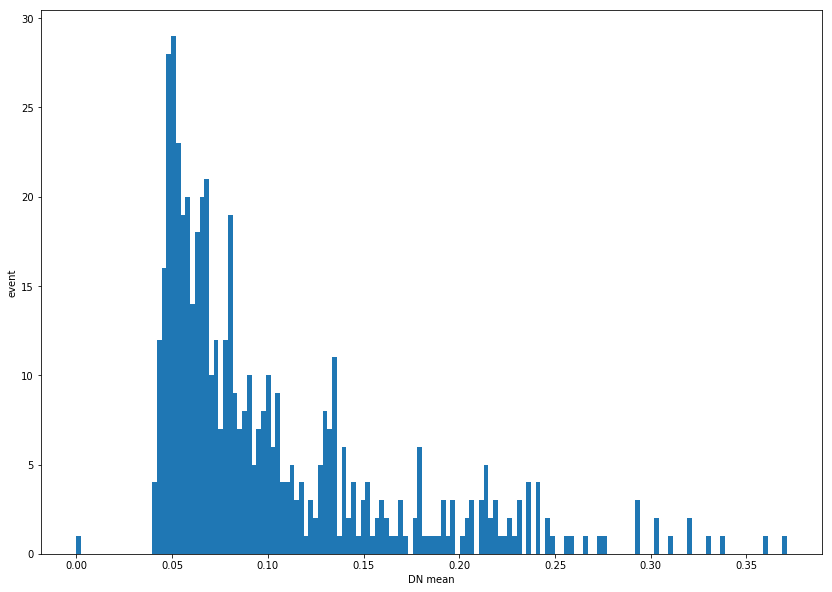

In [86]:
plt.figure(figsize=(14,10))
plt.hist(lpmt_event_DN_mean['isDN'], bins=150)
plt.xlabel("DN mean")
plt.ylabel("event")
plt.show()

Из гистограммы видим, что для большинства ивентов процент шумовых хитов не привышает 15%

In [18]:
lpmt_mpt_ID_DN_mean = lpmt.groupby(by='pmt_ID', as_index=False)['isDN'].mean()

#### Среднее количество шумовых хитов по фотоумножителю

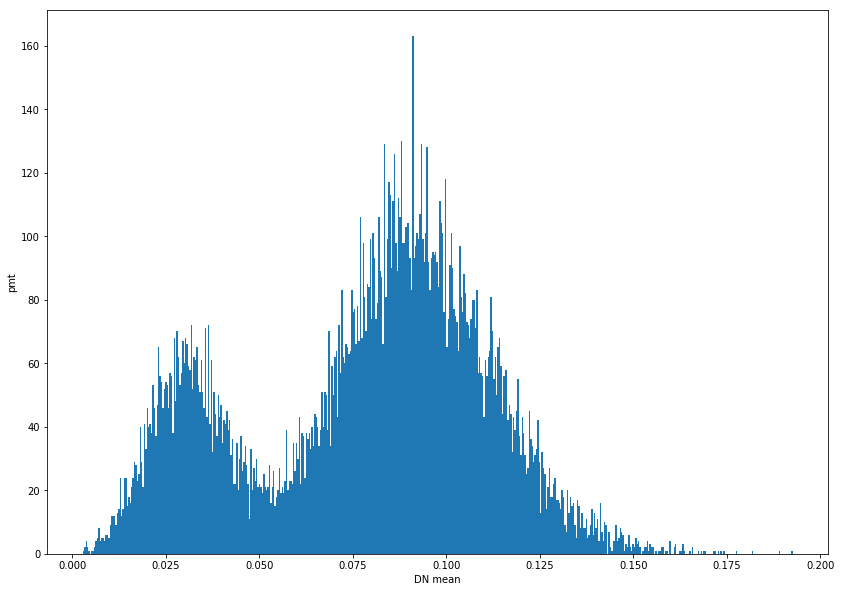

In [102]:
plt.figure(figsize=(14,10))
plt.hist(lpmt_mpt_ID_DN_mean['isDN'], bins=500)
plt.xlabel("DN mean")
plt.ylabel("pmt")
plt.show()

In [17]:
lpmt_n_hits.head()

,event,nHits
0,0,8902
1,1,7305
2,3,6718
3,4,5966
4,5,12744


#### Количество хитов по ивентам

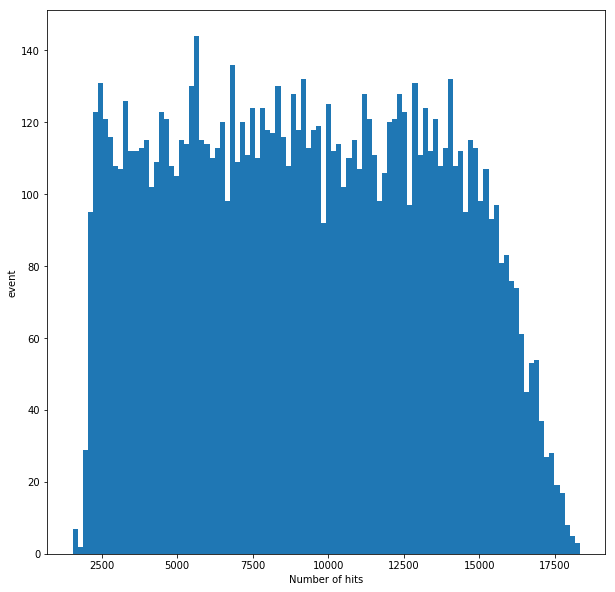

In [87]:
plt.figure(figsize=(10,10))
plt.hist(lpmt_n_hits['nHits'], bins = 100)
plt.xlabel("Number of hits")
plt.ylabel("event")
plt.show()

In [88]:
lpmt_complete = pd.merge(lpmt, train_info, how='inner', on='event')

In [90]:
lpmt_complete.head()

,event,hitTime,isDN,pmt_ID,nHits,E,R,x,y,z
0,0,249.992615,0,14175,8902,4.747791,14610.378,8290.779,11995.618,911.74286
1,0,40.010311,0,17319,8902,4.747791,14610.378,8290.779,11995.618,911.74286
2,0,162.123199,0,16882,8902,4.747791,14610.378,8290.779,11995.618,911.74286
3,0,51.875614,0,14951,8902,4.747791,14610.378,8290.779,11995.618,911.74286
4,0,79.817497,0,10947,8902,4.747791,14610.378,8290.779,11995.618,911.74286


In [92]:
init_hit = lpmt_complete.groupby(by='event', as_index=False)['hitTime'].min()
init_hit.rename(columns={'hitTime': 'init_hit'}, inplace=True)
lpmt_dif = lpmt_complete.merge(init_hit, how='inner', on='event')
lpmt_dif.head()

,event,hitTime,isDN,pmt_ID,nHits,E,R,x,y,z,init_hit
0,0,249.992615,0,14175,8902,4.747791,14610.378,8290.779,11995.618,911.74286,-97.573189
1,0,40.010311,0,17319,8902,4.747791,14610.378,8290.779,11995.618,911.74286,-97.573189
2,0,162.123199,0,16882,8902,4.747791,14610.378,8290.779,11995.618,911.74286,-97.573189
3,0,51.875614,0,14951,8902,4.747791,14610.378,8290.779,11995.618,911.74286,-97.573189
4,0,79.817497,0,10947,8902,4.747791,14610.378,8290.779,11995.618,911.74286,-97.573189


In [93]:
lpmt_dif['time_dif'] = lpmt_dif['hitTime'] - lpmt_dif['init_hit']

#### Время от начала ивента до хита по ивентам

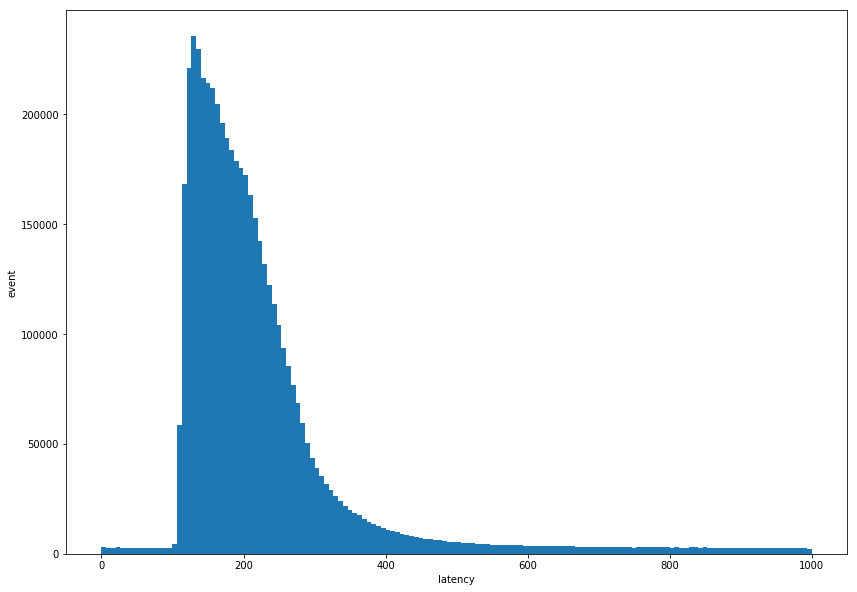

In [94]:
plt.figure(figsize=(14,10))
plt.hist(lpmt_dif['time_dif'], bins=150)
plt.xlabel('latency')
plt.ylabel('event')
plt.show()

In [99]:
init_hit = lpmt_complete[lpmt_complete['isDN'] == 0].groupby(by='event', as_index=False)['hitTime'].min()
init_hit.rename(columns={'hitTime': 'init_hit'}, inplace=True)
lpmt_dif = lpmt_complete.merge(init_hit, how='inner', on='event')
lpmt_dif['time_dif'] = lpmt_dif['hitTime'] - lpmt_dif['init_hit']
lpmt_dif.head()

,event,hitTime,isDN,pmt_ID,nHits,E,R,x,y,z,init_hit,time_dif
0,0,249.992615,0,14175,8902,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,225.987381
1,0,40.010311,0,17319,8902,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,16.005072
2,0,162.123199,0,16882,8902,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,138.117966
3,0,51.875614,0,14951,8902,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,27.870375
4,0,79.817497,0,10947,8902,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,55.812256


#### Время от начала ивента до хита по ивентам (без шумов)

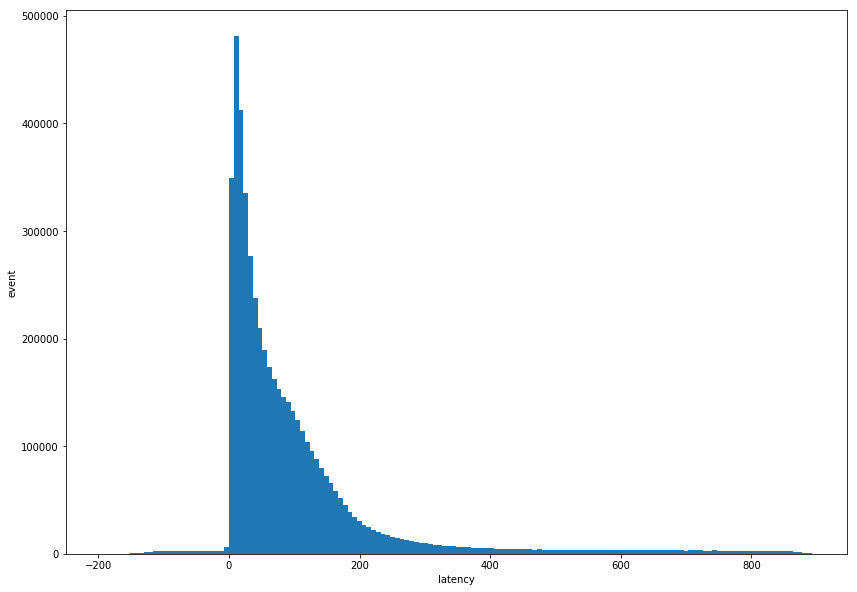

In [100]:
plt.figure(figsize=(14,10))
plt.hist(lpmt_dif['time_dif'], bins=150)
plt.xlabel('latency')
plt.ylabel('event')
plt.show()

In [101]:
lpmt_complete.head()

,event,hitTime,isDN,pmt_ID,nHits,E,R,x,y,z
0,0,249.992615,0,14175,8902,4.747791,14610.378,8290.779,11995.618,911.74286
1,0,40.010311,0,17319,8902,4.747791,14610.378,8290.779,11995.618,911.74286
2,0,162.123199,0,16882,8902,4.747791,14610.378,8290.779,11995.618,911.74286
3,0,51.875614,0,14951,8902,4.747791,14610.378,8290.779,11995.618,911.74286
4,0,79.817497,0,10947,8902,4.747791,14610.378,8290.779,11995.618,911.74286


In [11]:
event_id = 10000
lpmt_event_hits = lpmt_hits.loc[lpmt_hits['event'] == event_id]
spmt_event_hits = spmt_hits.loc[spmt_hits['event'] == event_id]

lpmt_hits_values = lpmt_event_hits['pmtID'].values
spmt_hits_values = spmt_event_hits['pmtID'].values

In [12]:
lpmt_hits_mask = []
for t in lpmt_pos.itertuples():
    if t[1] in lpmt_hits_values:
        lpmt_hits_mask.append("g")
    else:
        lpmt_hits_mask.append("r")
        
spmt_hits_mask = []
for t in spmt_pos.itertuples():
    if t[1] in spmt_hits_values:
        spmt_hits_mask.append("g")
    else:
        spmt_hits_mask.append("r")

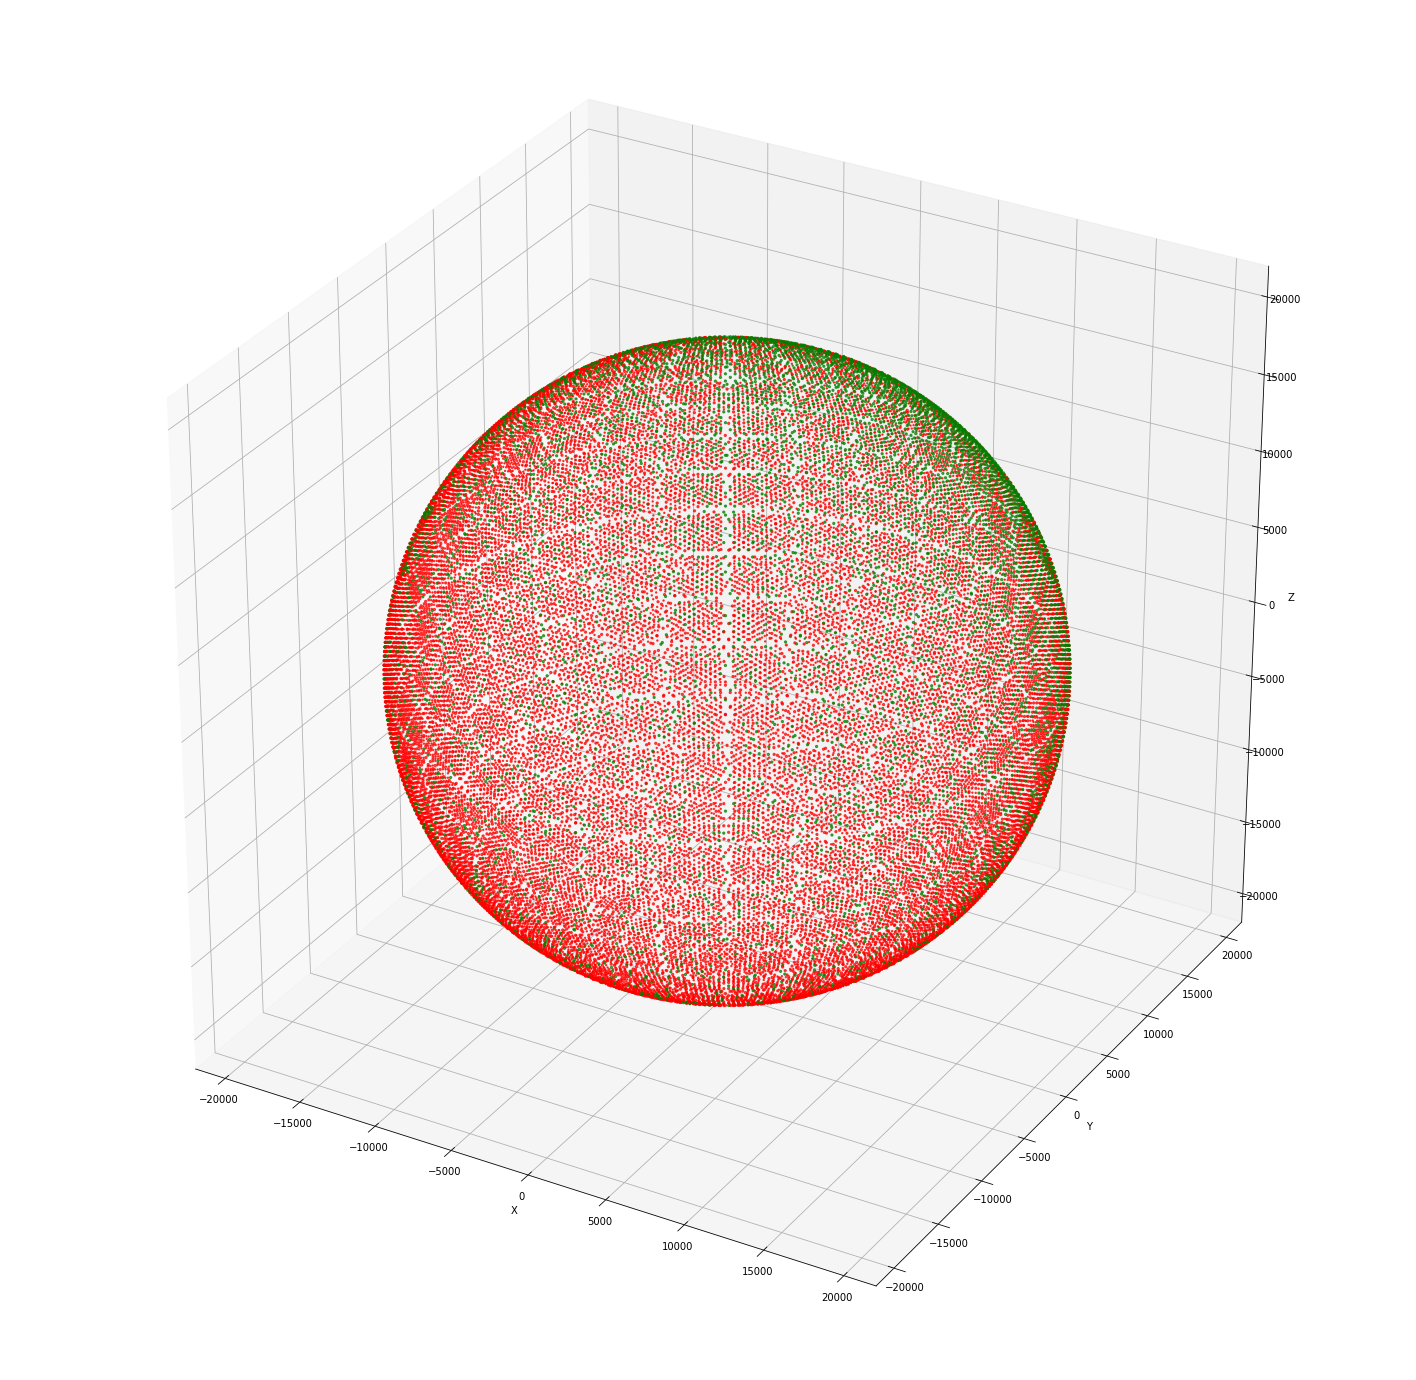

In [13]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

x = lpmt_pos['pmt_x']
y = lpmt_pos['pmt_y']
z = lpmt_pos['pmt_z']

ax.scatter(x, y, z, c=lpmt_hits_mask, marker='o', s=5, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

x = spmt_pos['pmt_x']
y = spmt_pos['pmt_y']
z = spmt_pos['pmt_z']

ax.scatter(x, y, z, c=spmt_hits_mask, marker='o', s=2, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()